## Загрузка и рисование файлов

In [28]:
# импорт бибилиотек
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
#библиотеки для графиков
import matplotlib.pyplot as plt
import seaborn as sns
#библиотеки для модели
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [29]:
#считывание данных
#NH3
nh3_2rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm.xlsx', sheet_name='Untitled')
nh3_25rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm_RH25%.xlsx', sheet_name='Untitled')
nh3_50rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm_RH50%.xlsx', sheet_name='Untitled')
nh3_75rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm_RH75%.xlsx', sheet_name='Untitled')
nh3_2rh_25t_another_ppm = pd.read_excel('Данные для МО/NH3_10_25_50 ppm_RH2%_Room temperature.xlsx', sheet_name='Untitled')

# NO2
no2_2rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_ RH_2%.xlsx', sheet_name='Untitled')
no2_25rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_25%.xlsx', sheet_name='Untitled')
no2_50rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_50%.xlsx', sheet_name='Untitled')
no2_75rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_75%.xlsx', sheet_name='Untitled')
no2_2rh_50t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_temp_50.xlsx', sheet_name='Untitled')
no2_2rh_70t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_temp_70_RH2%.xlsx', sheet_name='Untitled')
no2_2rh_90t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_temp_90.xlsx', sheet_name='Untitled')

In [30]:
#строим график зависимости сопротивления от времени
def dependency_graphs(gas, title):
    gas = gas.iloc[1:]# для того чтобы убрать (0,0)
    # Построим точечный график
    plt.figure(figsize=(6, 4))# размер графика
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas)# что и откуда берем

    plt.xlabel('Время')#ну как бы просто название
    plt.ylabel('Сопротивление')#название игрека
    title_string = f'Точечный график зависимости сопротивления от времени газа {title}'
    plt.title(title_string)
    plt.grid(True)#добавим сеточку

    return plt.show()

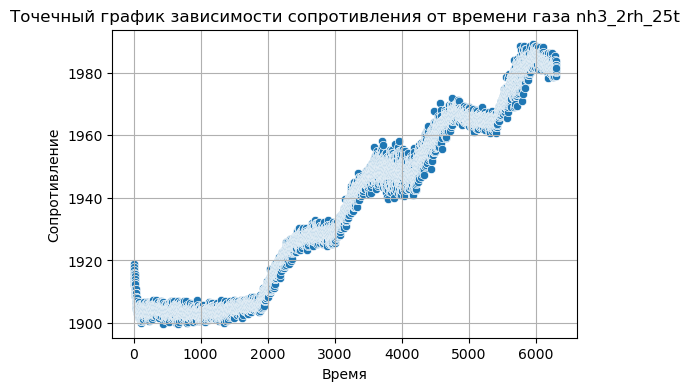

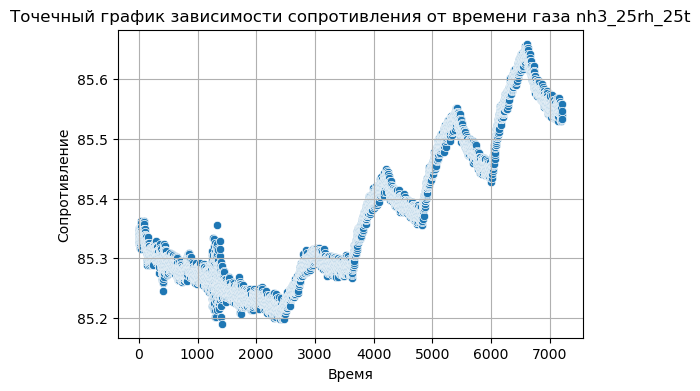

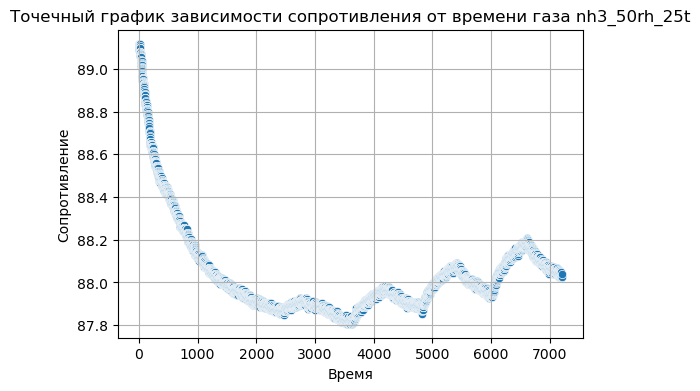

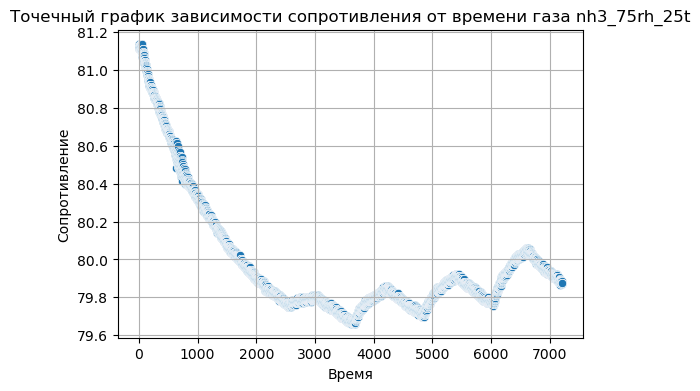

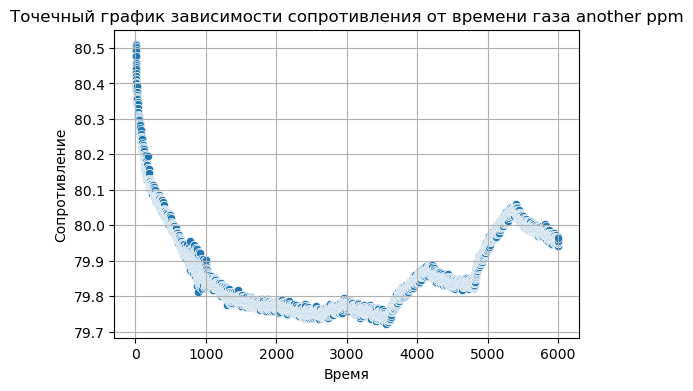

In [31]:
#графики NH3 при одинаковой температуре и разной влажности
nh3_2rh_25t_graph= dependency_graphs(nh3_2rh_25t, title = 'nh3_2rh_25t')
nh3_25rh_25t_graph = dependency_graphs(nh3_25rh_25t, title = 'nh3_25rh_25t')
nh3_50rh_25t_graph = dependency_graphs(nh3_50rh_25t, title = 'nh3_50rh_25t')
nh3_75rh_25t_graph = dependency_graphs(nh3_75rh_25t, title = 'nh3_75rh_25t')

nh3_2rh_25t_another_ppm_graph = dependency_graphs(nh3_2rh_25t_another_ppm, title='another ppm')

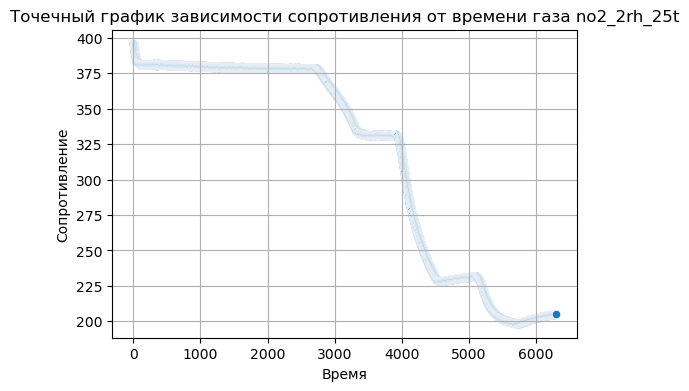

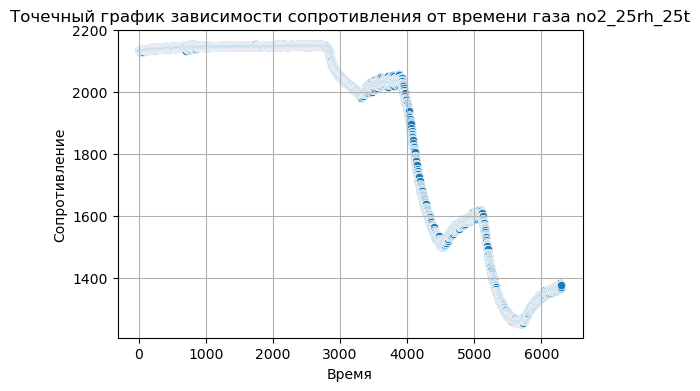

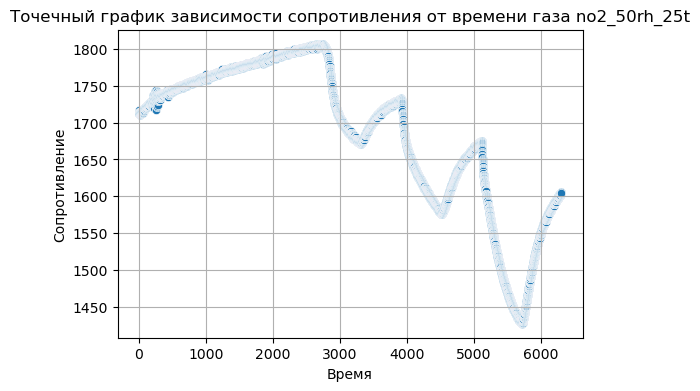

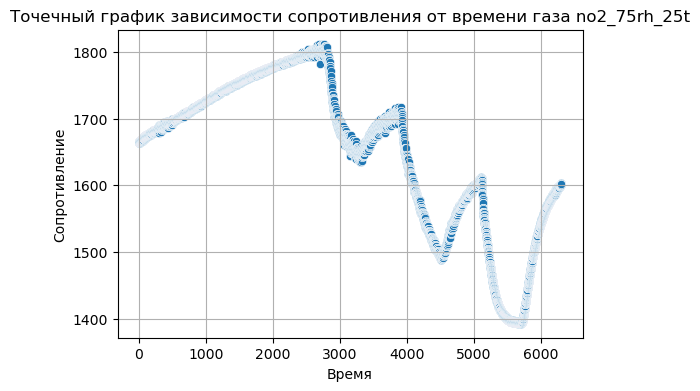

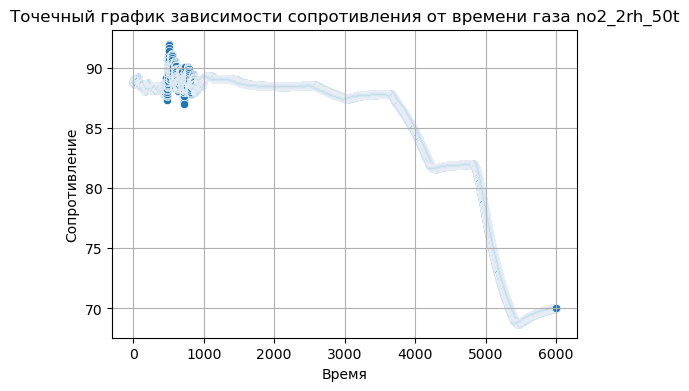

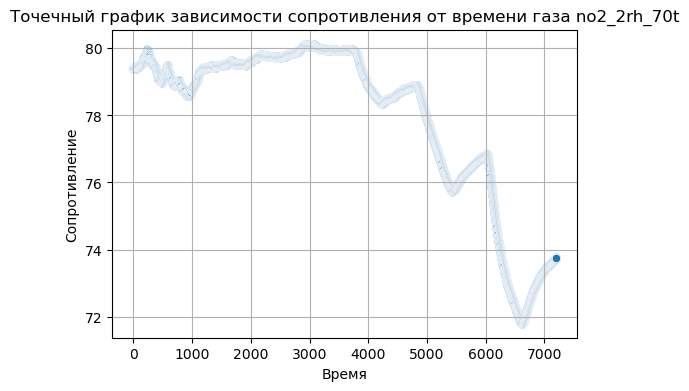

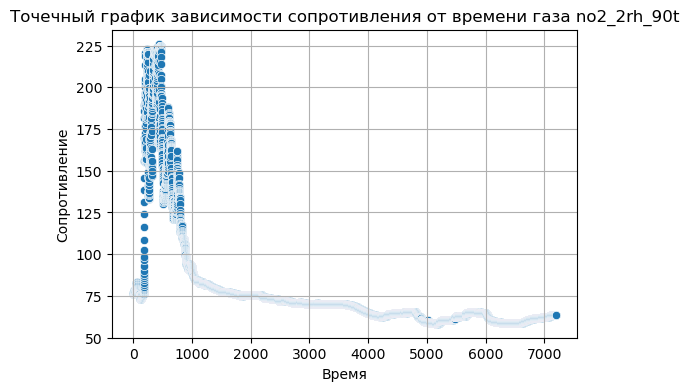

In [32]:
#графики NO2 при одинаковой температуре и разной влажности
no2_2rh_25t_graph = dependency_graphs(no2_2rh_25t, title = 'no2_2rh_25t')
no2_25rh_25t_graph = dependency_graphs(no2_25rh_25t, title = 'no2_25rh_25t')
no2_50rh_25t_graph = dependency_graphs(no2_50rh_25t, title = 'no2_50rh_25t')
no2_75rh_25t_graph = dependency_graphs(no2_75rh_25t, title='no2_75rh_25t')

#графики NO2 при температуре 50t
no2_2rh_50t_graph = dependency_graphs(no2_2rh_50t, title = 'no2_2rh_50t')

#графики NO2 при температуре 70t
no2_2rh_70t_graph = dependency_graphs(no2_2rh_70t,title='no2_2rh_70t')

#графики NO2 при температуре 90t
no2_2rh_90t_graph = dependency_graphs(no2_2rh_90t, title = 'no2_2rh_90t')

In [33]:
nh3_2rh_25t = nh3_2rh_25t.iloc[1:]
nh3_25rh_25t = nh3_25rh_25t.iloc[1:]
nh3_50rh_25t = nh3_50rh_25t.iloc[1:]
nh3_75rh_25t = nh3_75rh_25t.iloc[1:]

nh3_2rh_25t_another_ppm = nh3_2rh_25t_another_ppm.iloc[1:]



no2_2rh_25t = no2_2rh_25t.iloc[1:]
no2_25rh_25t = no2_25rh_25t.iloc[1:]
no2_50rh_25t = no2_50rh_25t.iloc[1:]
no2_75rh_25t = no2_75rh_25t.iloc[1:]


no2_2rh_50t = no2_2rh_50t.iloc[1:]


no2_2rh_70t = no2_2rh_70t.iloc[1:]


no2_2rh_90t = no2_2rh_90t.iloc[1:]
#nh3_2rh_25t

## Выявление тренда

Попробуем так: сначала усредним все точки, а потом найдем точки изменения тренда

In [34]:
def average_line_from_dataframe(df, resistance_col='R [Ом]', time_col='Time [с]', window_size=505, polynomial_order=3):
    """
    Проводим среднюю линию через множество точек зависимости сопротивления от времени,
    используя фильтр Савицкого-Голея
    Args:
        Датафрейм с данными: сопротивление и время!
        resistance_col (str): Название столбца с данными сопротивления
        time_col (str): Название столбца с данными времени
        window_size (int): Длина окна фильтра, должна быть нечетным числом.
                           Чем больше значение, тем более сглаженной будет кривая.
                           Рекомендуемые значения: 21, 51, 101(но нам сейчас не особо идут такие значения)
        polynomial_order (int): Порядок полинома, используемого для фильтрации
                                 Обычно используют 2 или 3
    Returns:
        array-like: Массив значений сглаженного сопротивления (средняя линия).
    """

    ################Проверка входных данных################
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Входные данные должны быть DataFrame.")

    if resistance_col not in df.columns or time_col not in df.columns:
        raise ValueError(f"DataFrame должен содержать столбцы '{resistance_col}' и '{time_col}'.")
    ############################################################################################
    
    #переводим в массиы нумпаевский
    time = df[time_col].to_numpy()
    resistance = df[resistance_col].to_numpy()

############Проверки массивов№№№№№№№№№№№№№№№№№№№№№№№№
    if len(time) != len(resistance):
        raise ValueError("Столбцы времени и сопротивления должны иметь одинаковую длину.")

    if window_size % 2 == 0:
        raise ValueError("Размер окна должен быть нечетным.")

    if window_size > len(resistance):
        raise ValueError("Размер окна не может быть больше длины данных.")

    #Фильтр Савицкого-Голея
    resistance_smooth = savgol_filter(resistance, window_size, polynomial_order)

    return resistance_smooth

# Параметры фильтра  
polynomial_order = 3


In [35]:
#применение
#NH3 temp = 25
res_average_nh3_2rh_25t= average_line_from_dataframe(nh3_2rh_25t,window_size=1101, polynomial_order=polynomial_order)# +++
res_average_nh3_25rh_25t = average_line_from_dataframe(nh3_25rh_25t,window_size=2009,polynomial_order=polynomial_order)# +++
res_average_nh3_50rh_25t = average_line_from_dataframe(nh3_50rh_25t,window_size=1501,polynomial_order=polynomial_order)# +++
res_average_nh3_75rh_25t = average_line_from_dataframe(nh3_75rh_25t, window_size=1707, polynomial_order=polynomial_order)# +++

# к сожалению, он не очень, его приблизить хорошо не удалось
res_average_nh3_2rh_25t_another_ppm = average_line_from_dataframe(nh3_2rh_25t_another_ppm, window_size=2209, polynomial_order=polynomial_order)

#NO2 temp = 25
#он тоже не очень приблизился
res_average_no2_2rh_25t = average_line_from_dataframe(no2_2rh_25t, window_size=101, polynomial_order=polynomial_order)#+--
#он тоже не очень приблизился
res_average_no2_25rh_25t = average_line_from_dataframe(no2_25rh_25t, window_size=1001, polynomial_order=polynomial_order)#+--
res_average_no2_50rh_25t = average_line_from_dataframe(no2_50rh_25t, window_size=1303, polynomial_order=polynomial_order)# +++
res_average_no2_75rh_25t = average_line_from_dataframe(no2_75rh_25t, window_size=1001, polynomial_order=polynomial_order)# +++

#NO2 temp = 50
res_average_no2_2rh_50t = average_line_from_dataframe(no2_2rh_50t, window_size=1909,polynomial_order=polynomial_order)# ++-

#NO2 temp = 70
#Я бы обрезала где=то 3500 тысячи секунд в начале, где происходит что-то непонятное
res_average_no2_2rh_70t = average_line_from_dataframe(no2_2rh_70t, window_size=4001, polynomial_order=polynomial_order)# ---

#NO2 temp = 90
res_average_no2_2rh_90t = average_line_from_dataframe(no2_2rh_90t, window_size=1301, polynomial_order=polynomial_order)# +++


In [36]:
def find_trend_change_point(smoothed_data, threshold=0):
    """
    Находит точку смены тренда в сглаженных данных, определяется по смене знака первой производной.
    Args:
        smoothed_data (array-like): Сглаженные данные
        threshold (float): Порог для определения смены тренда, учитывает небольшой шум.
    Returns:
        int: Индекс точки смены тренда. Возвращает None, если смена тренда не найдена.
    """
    # Вычисляем первую производную (разности)
    derivatives = np.diff(smoothed_data)

    # Находим индексы, где производная меняет знак
    trend_change_indices = np.where(np.diff(np.sign(derivatives)))[0] + 1  # +1 т.к. diff уменьшает размер массива на 1

    # Если индексы не найдены, возвращаем None
    if len(trend_change_indices) == 0:
        return None

    # Учитываем порог: проверяем, что изменение производной значительно (больше порога)
    for index in trend_change_indices:
      if abs(derivatives[index] - derivatives[index-1]) > threshold:
        return index

    return None  # Если ни одно изменение знака не превышает порог.

In [37]:
#NH3 temp = 25
trend_change_index_nh3_2rh_25t = find_trend_change_point(res_average_nh3_2rh_25t, threshold=0.005)# +++
trend_change_index_nh3_25rh_25t = find_trend_change_point(res_average_nh3_25rh_25t, threshold=0.00001)# +++
trend_change_index_nh3_50rh_25t = find_trend_change_point(res_average_nh3_50rh_25t,threshold=0.00001)# +++
trend_change_index_nh3_75rh_25t = find_trend_change_point(res_average_nh3_75rh_25t,threshold=0.00001)# +++

# к сожалению, он не очень, его приблизить хорошо не удалось
trend_change_index_nh3_2rh_25t_another_ppm = find_trend_change_point(res_average_nh3_2rh_25t_another_ppm,threshold=0.000000001)

#NO2 temp = 25
#он тоже не очень приблизился
trend_change_index_no2_2rh_25t = find_trend_change_point(res_average_no2_2rh_25t,threshold=0.00005)# +--
#он тоже не очень приблизился
trend_change_index_no2_25rh_25t = find_trend_change_point(res_average_no2_25rh_25t,threshold=0.01)#+--
trend_change_index_no2_50rh_25t = find_trend_change_point(res_average_no2_50rh_25t,threshold=0.001)# +++
trend_change_index_no2_75rh_25t = find_trend_change_point(res_average_no2_75rh_25t,threshold=0.00001)# +++

#NO2 temp = 50
trend_change_index_no2_2rh_50t = find_trend_change_point(res_average_no2_2rh_50t,threshold=0.0001)# ++-

#NO2 temp = 70
#Я бы обрезала где=то 3500 тысячи секунд в начале, где происходит что-то непонятное
trend_change_index_no2_2rh_70t = find_trend_change_point(res_average_no2_2rh_70t,threshold=0.00001)# ---

#NO2 temp = 90
trend_change_index_no2_2rh_90t = find_trend_change_point(res_average_no2_2rh_90t,threshold=0.001)# +++

In [38]:
def average_line_ris(df,resistance_smooth,trend_change_index, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time [с]'], df['R [Ом]'], label='Исходные данные')
    plt.plot(df['Time [с]'], resistance_smooth, label=f'Средняя линия (S-G, win=, order={polynomial_order})', linewidth=2)
    if trend_change_index is not None:
        plt.axvline(x=df['Time [с]'][trend_change_index], color='red', linestyle='--', label=f'Смена тренда (индекс {trend_change_index})')
    plt.xlabel('Время')
    plt.ylabel('Сопротивление')
    title_string = f'Сглаживание зависимости сопротивления от времени {title}'
    plt.title(title_string)
    plt.legend()
    plt.grid(True)
    plt.show()

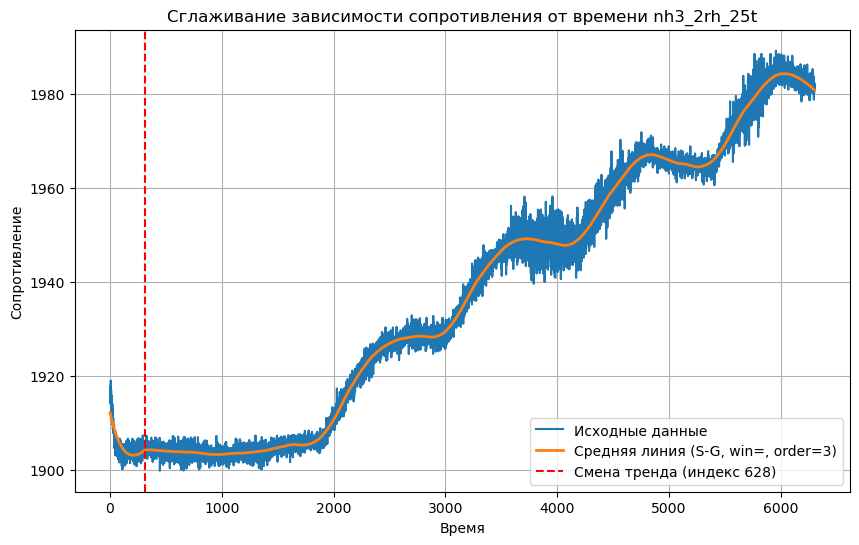

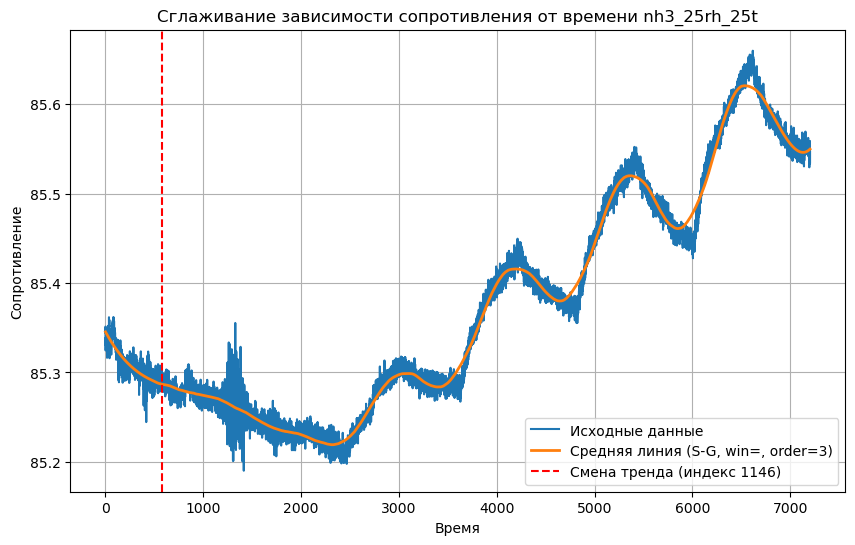

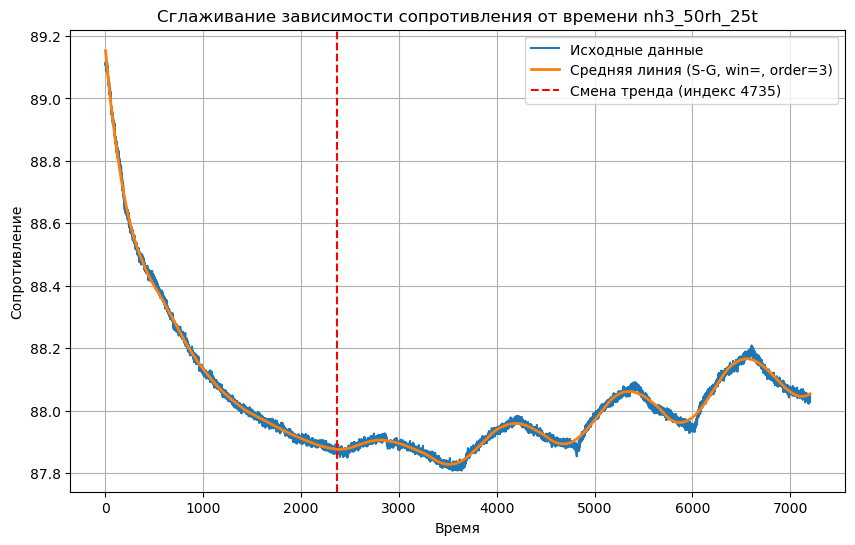

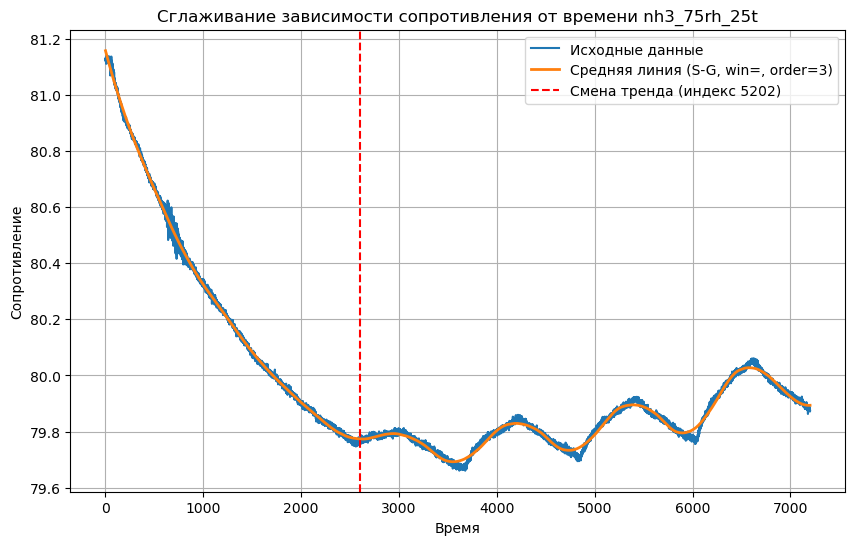

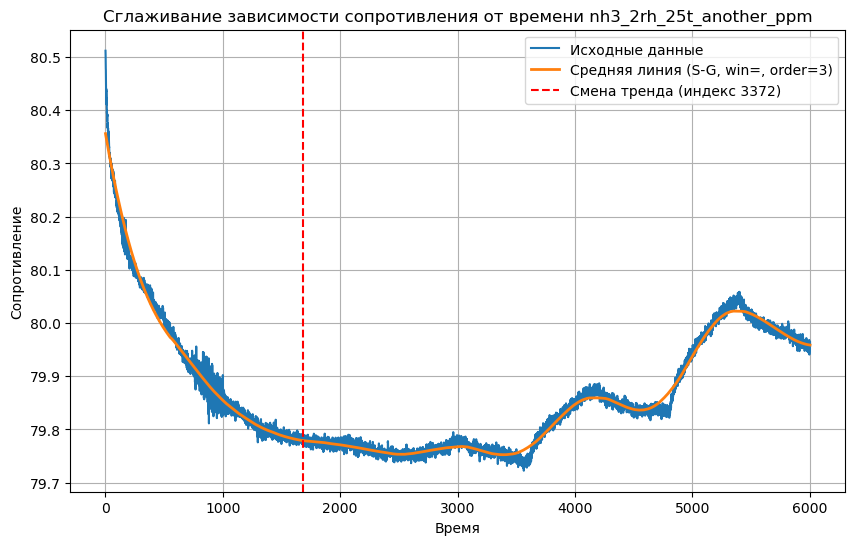

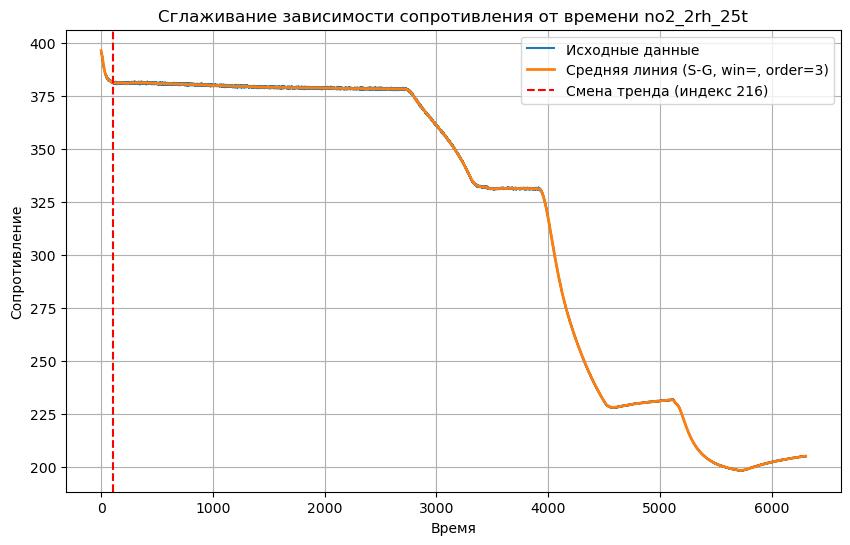

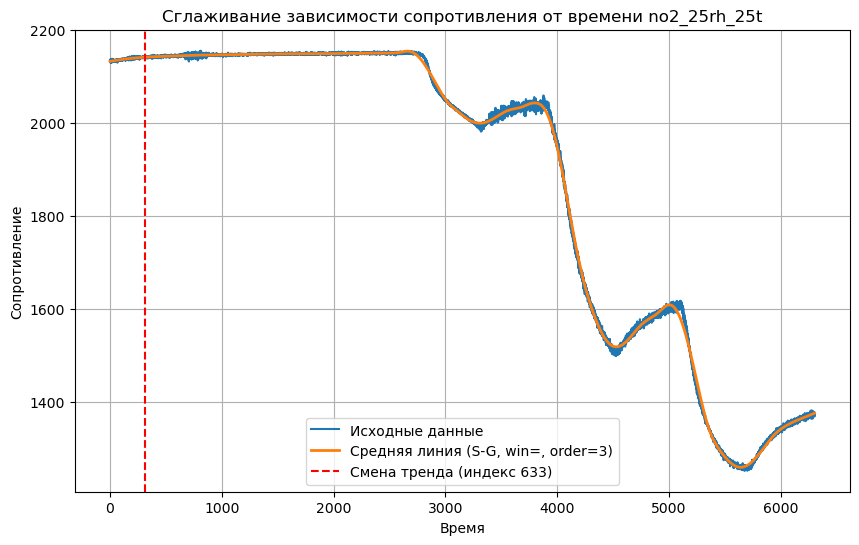

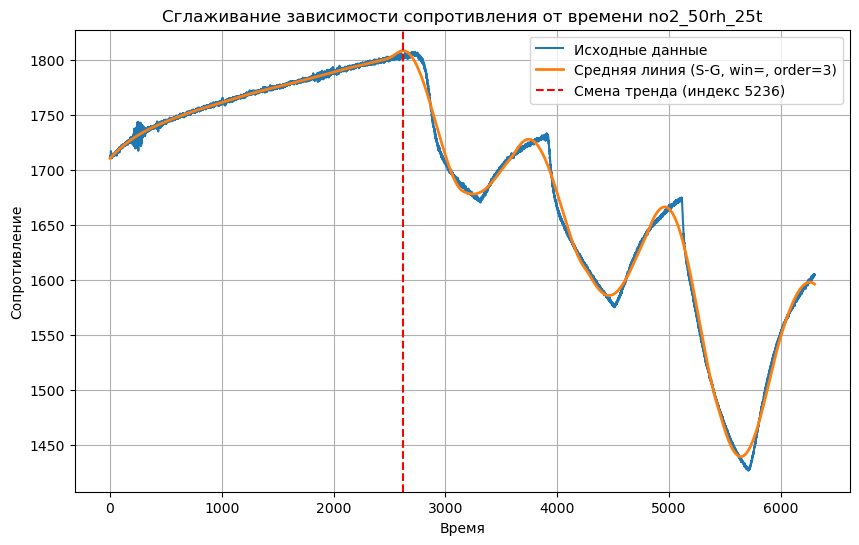

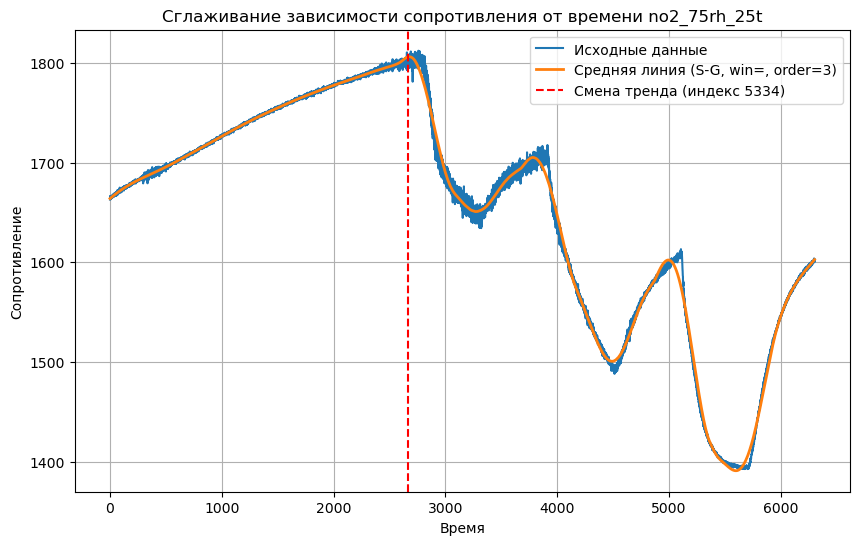

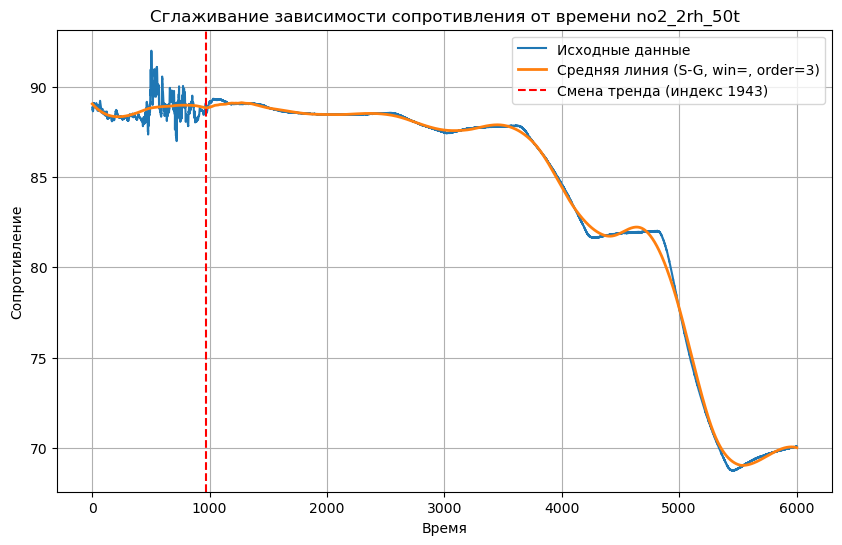

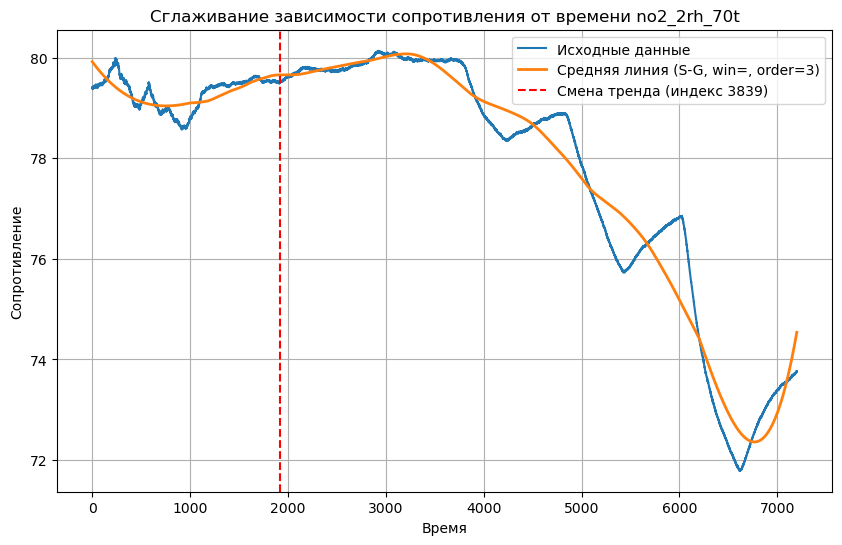

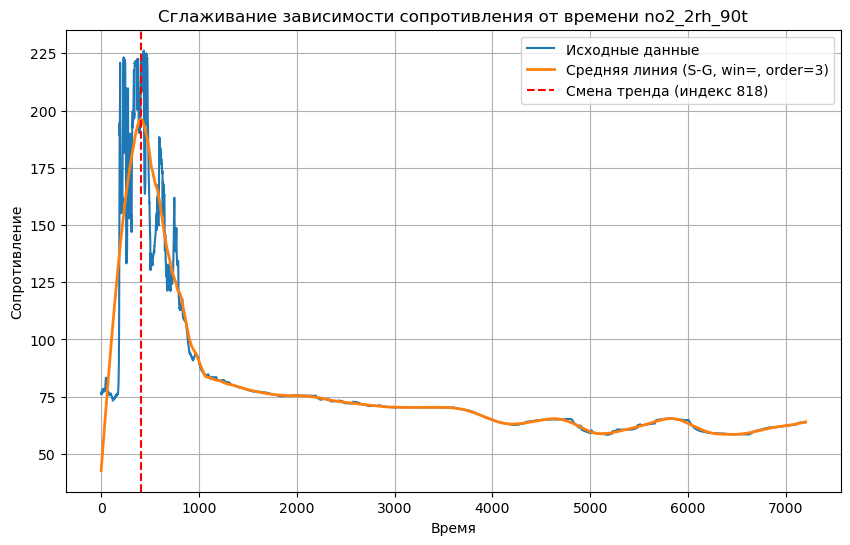

In [39]:
#NH3 temp - 25
nh3_2rh_25t_ris = average_line_ris(nh3_2rh_25t, res_average_nh3_2rh_25t, trend_change_index_nh3_2rh_25t, 'nh3_2rh_25t')# +++
nh3_25rh_25t_ris = average_line_ris(nh3_25rh_25t, res_average_nh3_25rh_25t, trend_change_index_nh3_25rh_25t, 'nh3_25rh_25t')# +++
nh3_50rh_25t_ris = average_line_ris(nh3_50rh_25t, res_average_nh3_50rh_25t, trend_change_index_nh3_50rh_25t, 'nh3_50rh_25t')# +++
nh3_75rh_25t_ris = average_line_ris(nh3_75rh_25t, res_average_nh3_75rh_25t, trend_change_index_nh3_75rh_25t, 'nh3_75rh_25t')# +++

# к сожалению, он не очень, его приблизить хорошо не удалось
nh3_2rh_25t_another_ppm_ris = average_line_ris(nh3_2rh_25t_another_ppm,res_average_nh3_2rh_25t_another_ppm,trend_change_index_nh3_2rh_25t_another_ppm, 'nh3_2rh_25t_another_ppm')

#NO2 temp - 25
#он тоже не очень приблизился
no2_2rh_25t_ris = average_line_ris(no2_2rh_25t, res_average_no2_2rh_25t, trend_change_index_no2_2rh_25t, 'no2_2rh_25t')#+--
#он тоже не очень приблизился
no2_25rh_25t_ris = average_line_ris(no2_25rh_25t, res_average_no2_25rh_25t, trend_change_index_no2_25rh_25t, 'no2_25rh_25t')#+--
no2_50rh_25t_ris = average_line_ris(no2_50rh_25t, res_average_no2_50rh_25t, trend_change_index_no2_50rh_25t, 'no2_50rh_25t')# +++
no2_75rh_25t_ris = average_line_ris(no2_75rh_25t, res_average_no2_75rh_25t, trend_change_index_no2_75rh_25t, 'no2_75rh_25t')# +++

#NO2 temp - 50
no2_2rh_50t_ris = average_line_ris(no2_2rh_50t, res_average_no2_2rh_50t, trend_change_index_no2_2rh_50t, 'no2_2rh_50t')# ++-

#NO2 temp - 70
#Я бы обрезала где=то 3500 тысячи секунд в начале, где происходит что-то непонятное
no2_2rh_70t_ris = average_line_ris(no2_2rh_70t, res_average_no2_2rh_70t, trend_change_index_no2_2rh_70t, 'no2_2rh_70t')# ---

#NO2 temp - 90
no2_2rh_90t_ris = average_line_ris(no2_2rh_90t, res_average_no2_2rh_90t, trend_change_index_no2_2rh_90t, 'no2_2rh_90t')# +++

In [40]:
nh3_2rh_25t = nh3_2rh_25t.iloc[627:]
nh3_2rh_25t

,R [Ом],Time [с]
628,1903.832397,314.0
629,1902.755371,314.5
630,1903.531372,315.0
631,1904.434692,315.5
632,1905.021484,316.0
...,...,...
12595,1980.580811,6300.0
12596,1982.384766,6300.5
12597,1980.985718,6301.0
12598,1981.931763,6301.5


In [41]:
nh3_25rh_25t = nh3_25rh_25t.iloc[1145:]
nh3_50rh_25t = nh3_50rh_25t.iloc[4734:]
nh3_75rh_25t = nh3_75rh_25t.iloc[5201:]

nh3_2rh_25t_another_ppm = nh3_2rh_25t_another_ppm.iloc[3371:]


no2_2rh_25t = no2_2rh_25t.iloc[215:]
no2_25rh_25t = no2_25rh_25t.iloc[632:]
no2_50rh_25t = no2_50rh_25t.iloc[5235:]
no2_75rh_25t = no2_75rh_25t.iloc[5333:]

no2_2rh_50t = no2_2rh_50t.iloc[1942:]

no2_2rh_70t = no2_2rh_70t.iloc[3499:]

no2_2rh_90t = no2_2rh_90t.iloc[817:]

no2_2rh_90t

,Time [с],R [Ом]
818,409.0,219.391556
819,410.0,221.059326
820,410.5,224.091324
821,411.0,223.474472
822,411.5,222.431854
...,...,...
14395,7200.5,63.783108
14396,7201.0,63.795902
14397,7201.5,63.803734
14398,7202.0,63.795231


Тут я задумалась, а дальше стоит генерировать просто обрезанные на такую длину датафреймы? Или лучше брать усредненную линию? В общем, сейчас попробуем с просто обрезанными датафреймами.<p>
Также что я еще заметила и подумала: для чего же искать эту точку смены тренда? Возможно, таким образом будет удобнее подавать в сеть и она будет лучше предсказывать. А может, потом в принципе придется менять подход? Или с помощью этого можно так скажем +- определить через какое же время "прибор" сможет начать предсказание? Так скажем чтобы точно не спутать
<br>
<br>
P.s. пишу ночью 07.02.2025

Ну, в общем-то, после обрезки вернемся к нашим собакам

## Дальнейшее преобразование

In [42]:
#функция для обработки - добавим отдельный столбик с температурой, с относительнеой влажностью(для каждого файла она своя, но постоянная)
def temperature_and_RH(df,t,rh):
    df['temperature[°C]'] = t
    df['RH[%]']=rh
    return df

#NH3 temp = 25s
nh3_2rh_25t = temperature_and_RH(nh3_2rh_25t,25,2)
nh3_25rh_25t = temperature_and_RH(nh3_2rh_25t,25,25)
nh3_50rh_25t = temperature_and_RH(nh3_50rh_25t,25,50)
nh3_75rh_25t = temperature_and_RH(nh3_75rh_25t,25,75)
nh3_2rh_25t_another_ppm = temperature_and_RH(nh3_2rh_25t_another_ppm,25,2)

#NO2 temp = 25
no2_2rh_25t = temperature_and_RH(no2_2rh_25t,25,2)
no2_25rh_25t = temperature_and_RH(no2_25rh_25t,25,25)
no2_50rh_25t = temperature_and_RH(no2_50rh_25t,25,50)
no2_75rh_25t = temperature_and_RH(no2_75rh_25t,25,75)

#NO2 temp = 50
no2_2rh_50t = temperature_and_RH(no2_2rh_50t,50,2)

#NO2 temp = 75
no2_2rh_70t = temperature_and_RH(no2_2rh_70t,70,2)

#NO2 temp = 90
no2_2rh_90t = temperature_and_RH(no2_2rh_90t,90,2)

#вывод
nh3_50rh_25t

,R [Ом],Time [с],temperature[°C],RH[%]
4735,87.868027,2368.5,25,50
4736,87.877785,2369.0,25,50
4737,87.879669,2369.5,25,50
4738,87.873260,2370.0,25,50
4739,87.882805,2370.5,25,50
...,...,...,...,...
14394,88.048531,7200.0,25,50
14395,88.035156,7200.5,25,50
14396,88.036003,7201.0,25,50
14397,88.027138,7201.5,25,50


In [43]:
# #ЗДЕСЬ ВОЗНИКАЮТ НАНЫ, избавление он nan'ов происходит ниже
# #ДОСТАТОЧНО МНОГО НУЛЕЙ ПОЯВЛЯЕТСЯ В СТОЛБЦЕ ПЕРИОДА 
# #функция для вычисления sin_time и cos_time

def sin_time_and_cos_time(df, time_column,R_column):
    df['period'] = df[R_column].diff()
    #print((df['period'] == 0).sum())
    #чтобы не появлялось нанов в столбцах с косинусом и синусом
    df.dropna(subset=['period'], inplace=True)

    df['sin_time'] = np.sin(2 * np.pi * df[time_column] / df['period'])
    df['cos_time'] = np.cos(2 * np.pi * df[time_column] / df['period'])
#удаляем временный столбец 'period'
    df.drop('period', axis=1, inplace=True)
    return df

#NH3 temp = 25
nh3_2rh_25t = sin_time_and_cos_time(nh3_2rh_25t,'Time [с]','R [Ом]')
nh3_25rh_25t = sin_time_and_cos_time(nh3_25rh_25t,'Time [с]','R [Ом]')
nh3_50rh_25t = sin_time_and_cos_time(nh3_50rh_25t,'Time [с]','R [Ом]')
nh3_75rh_25t = sin_time_and_cos_time(nh3_75rh_25t,'Time [с]','R [Ом]')
nh3_2rh_25t_another_ppm = sin_time_and_cos_time(nh3_2rh_25t_another_ppm, 'Time [с]','R [Ом]')

#NO2 temp = 25
no2_2rh_25t  = sin_time_and_cos_time(no2_2rh_25t,'Time [с]','R [Ом]')
no2_25rh_25t = sin_time_and_cos_time(no2_25rh_25t,'Time [с]','R [Ом]')
no2_50rh_25t = sin_time_and_cos_time(no2_50rh_25t,'Time [с]','R [Ом]')
no2_75rh_25t = sin_time_and_cos_time(no2_75rh_25t,'Time [с]','R [Ом]')

#NO2 temp = 50
no2_2rh_50t = sin_time_and_cos_time(no2_2rh_50t,'Time [с]','R [Ом]')

#NO2 temp = 70
no2_2rh_70t = sin_time_and_cos_time(no2_2rh_70t,'Time [с]','R [Ом]')

#NO2 temp = 90
no2_2rh_90t = sin_time_and_cos_time(no2_2rh_90t, 'Time [с]','R [Ом]')

#вывод
nh3_50rh_25t

c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in cos
  r

,R [Ом],Time [с],temperature[°C],RH[%],sin_time,cos_time
4736,87.877785,2369.0,25,50,0.993484,-0.113969
4737,87.879669,2369.5,25,50,0.509151,0.860677
4738,87.873260,2370.0,25,50,-0.974928,-0.222521
4739,87.882805,2370.5,25,50,0.999905,0.013812
4740,87.885033,2371.0,25,50,-0.917584,-0.397543
...,...,...,...,...,...,...
14394,88.048531,7200.0,25,50,-0.405654,0.914027
14395,88.035156,7200.5,25,50,-0.862116,0.506710
14396,88.036003,7201.0,25,50,0.605951,-0.795502
14397,88.027138,7201.5,25,50,-0.977277,-0.211965


In [44]:
#удаляем наны в датафрейме, а точнее заменяем их на предыдущее значение

#NH3 temp = 25
nh3_2rh_25t.fillna(method = "ffill", inplace=True)
nh3_25rh_25t.fillna(method = "ffill", inplace=True)
nh3_50rh_25t.fillna(method = "ffill", inplace=True)
nh3_75rh_25t.fillna(method = 'ffill', inplace=True)
nh3_2rh_25t_another_ppm.fillna(method='ffill', inplace=True)

#NO2 temp = 25
no2_2rh_25t.fillna(method='ffill', inplace=True)
no2_25rh_25t.fillna(method='ffill', inplace=True)
no2_50rh_25t.fillna(method='ffill', inplace=True)
no2_75rh_25t.fillna(method='ffill', inplace=True)

#NO2 temp = 50
no2_2rh_50t.fillna(method='ffill', inplace=True)

#NO2 temp = 75
no2_2rh_70t.fillna(method='ffill', inplace=True)

#NO2 temp = 90
no2_2rh_90t.fillna(method='ffill', inplace=True)

C:\Users\katya\AppData\Local\Temp\ipykernel_1484\1022477976.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nh3_2rh_25t.fillna(method = "ffill", inplace=True)
C:\Users\katya\AppData\Local\Temp\ipykernel_1484\1022477976.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nh3_25rh_25t.fillna(method = "ffill", inplace=True)
C:\Users\katya\AppData\Local\Temp\ipykernel_1484\1022477976.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nh3_50rh_25t.fillna(method = "ffill", inplace=True)
C:\Users\katya\AppData\Local\Temp\ipykernel_1484\1022477976.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nh3_75rh_25t.fillna(method = 

In [45]:
#проверка на отсутствие нанов

#NH3 temp = 25
nh3_2rh_25t.isnull().sum()
nh3_25rh_25t.isnull().sum()
# nh3_50rh_25t.isnull().sum()
# nh3_75rh_25t.isnull().sum()
nh3_2rh_25t_another_ppm.isnull().sum()

#NO2 temp = 25
no2_2rh_25t.isnull().sum()
no2_25rh_25t.isnull().sum()
no2_50rh_25t.isnull().sum()
no2_75rh_25t.isnull().sum()

#NO2 temp = 50
no2_2rh_50t.isnull().sum()

#NO2 temp = 70
no2_2rh_70t.isnull().sum()

#NO2 temp = 90
no2_2rh_90t.isnull().sum()

Time [с]           0
R [Ом]             0
temperature[°C]    0
RH[%]              0
sin_time           0
cos_time           0
dtype: int64

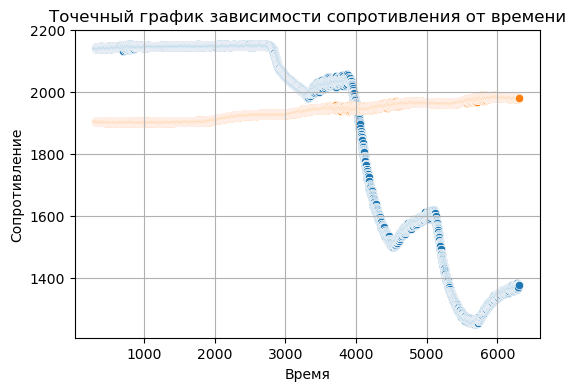

In [46]:
#проверим. что при нормализации ничего толком не поменялось, а также посмотрим на зависимость
def two_graphs(gas1, gas2):
    gas1 = gas1.iloc[1:]
    gas2 = gas2.iloc[1:]

    # Построим точечный график
    plt.figure(figsize=(6, 4))# размер графика
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas1)# что и откуда берем
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas2)

    plt.xlabel('Время')#ну как бы просто название
    plt.ylabel('Сопротивление')#название игрека
    plt.title('Точечный график зависимости сопротивления от времени')
    plt.grid(True)#добавим сеточку

    return plt.show()
dependency_graph = two_graphs(no2_25rh_25t, nh3_2rh_25t)#первый график - синий, второй - оранжевый

In [47]:
#целевая переменная
def target(df,value):
    df['y'] = value
    return df

#NH3 temp = 25
nh3_2rh_25t = target(nh3_2rh_25t,1)
nh3_25rh_25t = target(nh3_25rh_25t,1)
nh3_50rh_25t = target(nh3_50rh_25t,1)
nh3_75rh_25t = target(nh3_75rh_25t,1)
nh3_2rh_25t_another_ppm = target(nh3_2rh_25t_another_ppm,1)

#NO2 temp = 25
no2_2rh_25t = target(no2_2rh_25t,0)
no2_25rh_25t = target(no2_25rh_25t,0)
no2_50rh_25t = target(no2_50rh_25t,0)
no2_75rh_25t = target(no2_75rh_25t,0)

#NO2 temp = 50
no2_2rh_50t = target(no2_2rh_50t,0)

#NO2 temp = 70
no2_2rh_70t = target(no2_2rh_70t,0)

#NO2 temp = 90
no2_2rh_90t = target(no2_2rh_90t,0)
#вывод
no2_2rh_25t

,R [Ом],Time [с],temperature[°C],RH[%],sin_time,cos_time,y
217,381.018127,108.5,25,2,0.992082,-0.125589,0
218,381.320160,109.0,25,2,-0.645378,0.763864,0
219,381.562805,109.5,25,2,0.986619,-0.163046,0
220,381.214417,110.0,25,2,0.997746,-0.067096,0
221,381.323975,110.5,25,2,-0.573537,-0.819180,0
...,...,...,...,...,...,...,...
12595,205.186600,6300.0,25,2,-0.580102,0.814544,0
12596,205.107727,6300.5,25,2,0.561022,0.827801,0
12597,205.248077,6301.0,25,2,-0.958055,0.286585,0
12598,205.188324,6301.5,25,2,-0.575255,-0.817974,0


In [48]:
##############ДЛЯ ТРЭЙН ТЕСТА###########################
########ВНИМАНИЕ#####
#данные для обучения состоят только из конкатенации этих двух файлов
common_data = pd.concat([nh3_2rh_25t,
                         nh3_25rh_25t,
                         nh3_50rh_25t,
                         nh3_75rh_25t, 
                         nh3_2rh_25t_another_ppm, 
                         no2_2rh_25t, 
                         no2_25rh_25t,
                         no2_50rh_25t, 
                         no2_75rh_25t, 
                         no2_2rh_50t, 
                         no2_2rh_70t,
                         no2_2rh_90t,], ignore_index=True)

# Отделим целевую переменную в список
target_data = common_data['y'].tolist()

#теперь избавимся от столбца y
common_data_no_y = common_data.drop('y', axis = 1)

#Преобразуем теперь наши данные в список(для обучения надо так)
def dataframe_to_list_of_lists(df):
    """Преобразует датафрейм в список списков, где каждый внутренний список представляет строку датафрейма"""
    list_of_lists = []
    for _, row in df.iterrows():
        list_of_lists.append(row.tolist())
    return list_of_lists

X_data = dataframe_to_list_of_lists(common_data_no_y)
X_data

[[1903.5313720703125,
  315.0,
  25.0,
  25.0,
  -0.44093079437967136,
  0.8975411046674754],
 [1904.4346923828125,
  315.5,
  25.0,
  25.0,
  0.9942826718000842,
  -0.10678000074024148],
 [1905.021484375, 316.0, 25.0, 25.0, -0.1335763538664463, -0.9910385248252188],
 [1903.2147216796875,
  316.5,
  25.0,
  25.0,
  -0.8915503283584442,
  0.4529216400261202],
 [1905.474853515625,
  317.0,
  25.0,
  25.0,
  0.9989468733250799,
  -0.04588185124912292],
 [1902.9613037109375,
  317.5,
  25.0,
  25.0,
  -0.9168025064982961,
  -0.39934091210198047],
 [1904.4588623046875,
  318.0,
  25.0,
  25.0,
  0.8249038207382833,
  -0.5652731079145569],
 [1906.0294189453125,
  318.5,
  25.0,
  25.0,
  -0.9614394786615116,
  0.27501659744655543],
 [1904.0777587890625,
  319.0,
  25.0,
  25.0,
  -0.3055015560425861,
  -0.9521915769715454],
 [1904.712646484375, 319.5, 25.0, 25.0, 0.9974393671599, 0.07151719261588853],
 [1904.05419921875,
  320.0,
  25.0,
  25.0,
  0.05123083623361492,
  0.9986868385128566],


In [49]:
# Разделение на тренировочную и валидационную выборки
# в целом здесь можно конечно посмотреть и еще некоторые атрибуты, чтобы разделит удобно, но в целом
#итак неплохо 
X_train, X_val, y_train, y_val = train_test_split(X_data, target_data, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(f"Размер тренировочной выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_val)}")
print(f"Размер тестовой выборки: {len(X_test)}")
class_0_count = 0
class_1_count = 0

for element in y_test:
    if element == 0:
        class_0_count += 1
    elif element == 1:
        class_1_count += 1

print(f"Количество элементов класса 0(диоксид азота): {class_0_count}")
print(f"Количество элементов класса 1(аммиак): {class_1_count}")


Размер тренировочной выборки: 99939
Размер валидационной выборки: 12492
Размер тестовой выборки: 12493
Количество элементов класса 0(диоксид азота): 7339
Количество элементов класса 1(аммиак): 5154


In [50]:
# Преобразование данных в тензоры PyTorch
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)# из нумпая в тензор, данные как float32 
y_train_tensor = torch.tensor(y_train, dtype=torch.long) #long -  для классификации(указывает типа, что это прям переменные класса именно, а не просто признаки)


x_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


# Модель RNN
class SimpleRNN(nn.Module):#базовый модуль для всех нейронок библиотеки
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()# конструктор из класса-родителя, для инициализации
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)#dim батча - первая размерность входного тензора
        self.fc = nn.Linear(hidden_size, output_size)#полностью связанный слой, используется для преобразования скрытого состояния в выходной вектор
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #Создаем тензор нулей, начальное скрытое состояние (h0)
        #1: dim, соответствующая направлению RNN (в данном случае - 1, так как RNN не двунаправленный)
        #x.size(0): Размер батча (количество примеров в батче)
        #self.hidden_size: Размер скрытого состояния
        h0 = torch.zeros(1, x.size(0), self.hidden_size)# Инициализация hidden state, важное изменение для batch_first=True
        out, hn = self.rnn(x, h0) #hn - последнее скрытое состояние, out - выход rnn содержит скрытое состояние на каждом временном шаге
        out = self.fc(out[:, -1, :]) #все элементы батча, посл вр шаг, все знач скрыт. сост.
        out = self.sigmoid(out)
        return out

# Гиперпараметры
input_size = 6# количество элементов в каждом подмассиве нашего массива
hidden_size = 16# подбираем сами, такое количество вполне норм сейчас
output_size = 1# выходной слой
learning_rate = 0.01# размер шага для нашего алгоритма оптимизации
epochs = 300
batch_size = len(X_train)#соответствует длине данных, В ОБЩЕМ СЛУЧАЕ ЛУЧШЕ ЧУТЬ ПОДПРАВИТЬ ЭТО


model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss() # Бинарная кросс-энтропия
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение
for epoch in range(epochs):
    optimizer.zero_grad()#сбрасываем градиенты оптимизатора до нуля, иначе с расчетом весов будет проблема
    outputs = model(x_train_tensor.unsqueeze(1)) # Добавляем дополнительную размерность для времени
    loss = criterion(outputs.squeeze(1), y_train_tensor.float()) # Снимаем лишнее измерение
    loss.backward()
    optimizer.step()#обновляем веса модели
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            train_predictions = (model(x_train_tensor.unsqueeze(1)) > 0.5).float()
            train_accuracy = accuracy_score(y_train_tensor.numpy(), train_predictions.squeeze(1).numpy())

            # Оценка на валидационных данных
            val_predictions = (model(x_val_tensor.unsqueeze(1)) > 0.5).float()
            val_loss = criterion(val_predictions.squeeze(1), y_val_tensor.float())
            val_accuracy = accuracy_score(y_val_tensor.numpy(), val_predictions.squeeze(1).numpy())

            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, '
                  f'Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')


#Оценка точности после обучения
with torch.no_grad():
    predictions = (model(x_train_tensor.unsqueeze(1)) > 0.5).float()
    accuracy = accuracy_score(y_train_tensor.numpy(), predictions.squeeze(1).numpy())
    print(f'\nTrain Accuracy: {accuracy:.4f}')

with torch.no_grad():
    final_val_predictions = (model(x_val_tensor.unsqueeze(1)) > 0.5).float()
    final_val_accuracy = accuracy_score(y_val_tensor.numpy(), final_val_predictions.squeeze(1).numpy())
    print(f'\nValidation Accuracy: {final_val_accuracy:.4f}')


Epoch [10/300], Loss: 0.6389, Accuracy: 0.6241, Val Loss: 37.4480, Val Accuracy: 0.6255
Epoch [20/300], Loss: 0.6042, Accuracy: 0.5892, Val Loss: 41.7387, Val Accuracy: 0.5826
Epoch [30/300], Loss: 0.6210, Accuracy: 0.6301, Val Loss: 36.9436, Val Accuracy: 0.6306
Epoch [40/300], Loss: 0.6100, Accuracy: 0.6330, Val Loss: 36.6875, Val Accuracy: 0.6331
Epoch [50/300], Loss: 0.5733, Accuracy: 0.6268, Val Loss: 37.3519, Val Accuracy: 0.6265
Epoch [60/300], Loss: 0.5328, Accuracy: 0.7899, Val Loss: 20.5091, Val Accuracy: 0.7949
Epoch [70/300], Loss: 0.5059, Accuracy: 0.8170, Val Loss: 17.8834, Val Accuracy: 0.8212
Epoch [80/300], Loss: 0.4843, Accuracy: 0.8120, Val Loss: 18.5559, Val Accuracy: 0.8144
Epoch [90/300], Loss: 0.4733, Accuracy: 0.8234, Val Loss: 17.4191, Val Accuracy: 0.8258
Epoch [100/300], Loss: 0.4762, Accuracy: 0.8120, Val Loss: 18.2757, Val Accuracy: 0.8172
Epoch [110/300], Loss: 0.4701, Accuracy: 0.8304, Val Loss: 16.7387, Val Accuracy: 0.8326
Epoch [120/300], Loss: 0.5254,

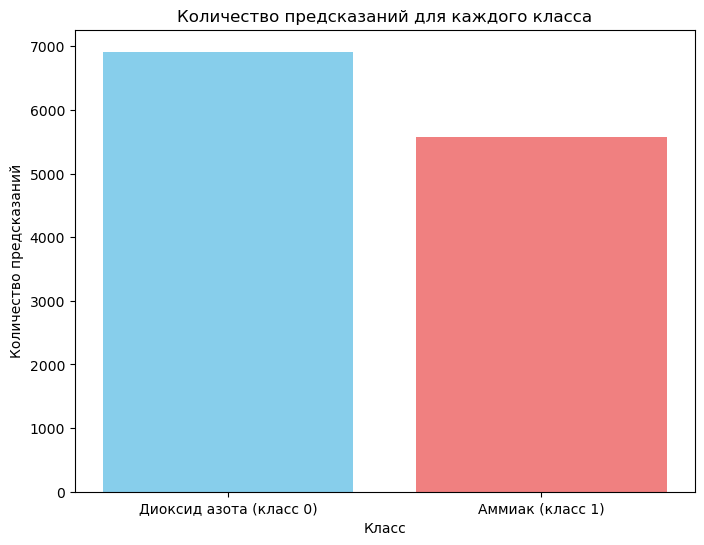

Вероятность принадлежности к классу диоксида азота: 0.9137110412120819 - это диоксид азота
Вероятность принадлежности к классу диоксида азота: 0.9137110412120819 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.6770297884941101 - это аммиак
Вероятность принадлежности к классу диоксида азота: 0.9137110412120819 - это диоксид азота
Вероятность принадлежности к классу диоксида азота: 0.9137110412120819 - это диоксид азота
Вероятность принадлежности к классу диоксида азота: 0.9137110412120819 - это диоксид азота
Вероятность принадлежности к классу диоксида азота: 0.9137110412120819 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.6770297884941101 - это аммиак
Вероятность принадлежности к классу аммиака: 0.6770297884941101 - это аммиак
Вероятность принадлежности к классу аммиака: 0.6770297884941101 - это аммиак
Вероятность принадлежности к классу диоксида азота: 0.9137110412120819 - это диоксид азота
Вероятность принадлежности к классу диоксида азота: 0.9

In [51]:
# Преобразование тестовых данных
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Оценка на тестовой выборке
with torch.no_grad():
    test_outputs = model(x_test_tensor.unsqueeze(1))
    test_predictions = (test_outputs > 0.5).float()
    #test_accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions.squeeze(1).numpy())

#print(f'Test Accuracy: {test_accuracy:.4f}')
# Подсчет количества предсказаний для каждого класса
class_counts = test_predictions.squeeze(1).numpy()
unique, counts = np.unique(class_counts, return_counts=True)
class_counts_dict = dict(zip(unique, counts))

# Построение графика
labels = ['Диоксид азота (класс 0)', 'Аммиак (класс 1)']
counts = [class_counts_dict.get(0.0,0), class_counts_dict.get(1.0,0)] #Обработка случая, если какого-то класса нет в предсказаниях

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'lightcoral'])
plt.title('Количество предсказаний для каждого класса')
plt.ylabel('Количество предсказаний')
plt.xlabel('Класс')
plt.show()

nh3 = 0
no2 = 0
# Логика для вывода класса
for i, prob in enumerate(test_outputs.squeeze(1)):
    if prob.item() > 0.5:
        nh3+=1
        print(f"Вероятность принадлежности к классу аммиака: {prob.item()} - это аммиак")
    else:
        no2+=1
        print(f"Вероятность принадлежности к классу диоксида азота: {1-prob.item()} - это диоксид азота")
print(f"Количество предсказаний за аммиак: {nh3}")
print(f"Количество предсказаний за диоксид азота: {no2}")